# Course Project - Fact or Fake News: Developing a Fact Checking Algorithm


### Install Relevant Libraries

In [0]:
!pip install numpy
!pip install pandas
!pip install matplotlib.pyplot
!pip install seaborn
!pip install sklearn
!pip install nltk
!pip install textBlob

  ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


### Import Relevant Libaries

In [0]:
import numpy as np
import pandas as pd
import re, nltk
import string
import random
import json
import os
import html
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords
from sklearn.naive_bayes import BernoulliNB
from wordcloud import WordCloud
from textblob import TextBlob 

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import warnings
warnings.filterwarnings("ignore")

### Read in Data

In [0]:
df = pd.read_json("train.json")

In [0]:
df.head()

,claim,claimant,date,id,label,related_articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [0]:
df['claim'][0]

"A line from George Orwell's novel 1984 predicts the power of smartphones."

#### Related Articles

For importing the related articles to the dataframe, we will only import two related articles for each data which is the minimum number of related articles each data can have.

In [0]:
related_articles = df['related_articles'].copy()

In [0]:
#Get current directory
cdir = os.getcwd()

# Define Paths from current file directory to the train articles. Note that the train articles folder 
# needs to be in the same directory as the Python file
ARTICLES_FILEPATH  = cdir + "\\train_articles"

In [0]:
articles = []
for idx in range(len(related_articles)):
    article = ''
    for ids in related_articles[idx][:2]:
        with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % ids), 'r', encoding = 'UTF8') as f:
            article += f.read()
    articles.append(article)

In [0]:
df['article']= articles

In [0]:
df['article'].head()

0    1984: George Orwell predicted 2017 almost 70 y...
1    Republican who criticized Parkland students dr...
2    FIRST PERSON TO COMPLETE NASA’S PASSPORT PROGR...
3    How dangerous is measles? Tweet\n\n27 March 20...
4    Remarks on counterterrorism at Stanford Univer...
Name: article, dtype: object

## 1.0 Data Cleaning

The texts, as given, are not in a form amenable to analysis -- there is too much ‘noise’. Therefore, we will clean the data through the approaches as follows:

* Change all characters in the text are in lowercase.
* Remove all stop words are removed using NLTK library
* Remove all punctuation
* Apply stemming
* Clean html Codes and Emojis
* Clean html tags

In [0]:
# Stop Words in nltk
stop_nltk = set(stopwords.words('english'))

In [0]:
#Convert to lower case
def lower_case(claim):
    claim = claim.lower()
    return claim

#Remove all html tags and attributes
def clean_html_tags(claim):
    tags = re.compile(r'<[^>]+>')
    claim = re.sub(tags, ' ' , claim)
    return claim

#Clean html character code
def clean_html_codes(claim):
    claim = html.unescape(claim)
    return claim

# Tokenization - Converting a sentence into list of words
def tokenization(claim):
    claim = re.split('\W+', claim)
    return claim

def remove_stop_words(claim):
    claim = [word for word in claim if word not in stop_nltk] 
    return claim    
 
# Remove Punctuation
def remove_punc(claim):
    claim = [char for char in claim if char not in string.punctuation]
    return claim
 
sm = nltk.PorterStemmer()
 
def stem(claim):
    claim = [sm.stem(word) for word in claim]
    return claim   
 
def clean_data(data):
     
    data = data.apply(lambda x: lower_case(x))
    data = data.apply(lambda x: clean_html_tags(x))
    data = data.apply(lambda x: clean_html_codes(x))
    data = data.apply(lambda x: tokenization(x))    
    data = data.apply(lambda x: remove_stop_words(x))   
    data = data.apply(lambda x: remove_punc(x)) 
    data = data.apply(lambda x: stem(x)) 

    
    return data

In [0]:
#Clean Claim Data
df['clean'] = clean_data(df['claim'])
df['clean_joined'] = df['clean'].apply(lambda x: ' '.join(x))

In [0]:
#Clean Articles Data
df['clean_article'] = clean_data(df['article'])
df['clean_article_joined'] = df['clean_article'].apply(lambda x: ' '.join(x))

## 2.0 Explanatory Data Analysis 

### Label Distribution

In [0]:
#Replace numerical labels with truth ratings
new_label = df['label'].copy()

new_label.replace({0:'False',1:'Partly True', 2: 'True'}, inplace = True)

df['new_label'] = new_label

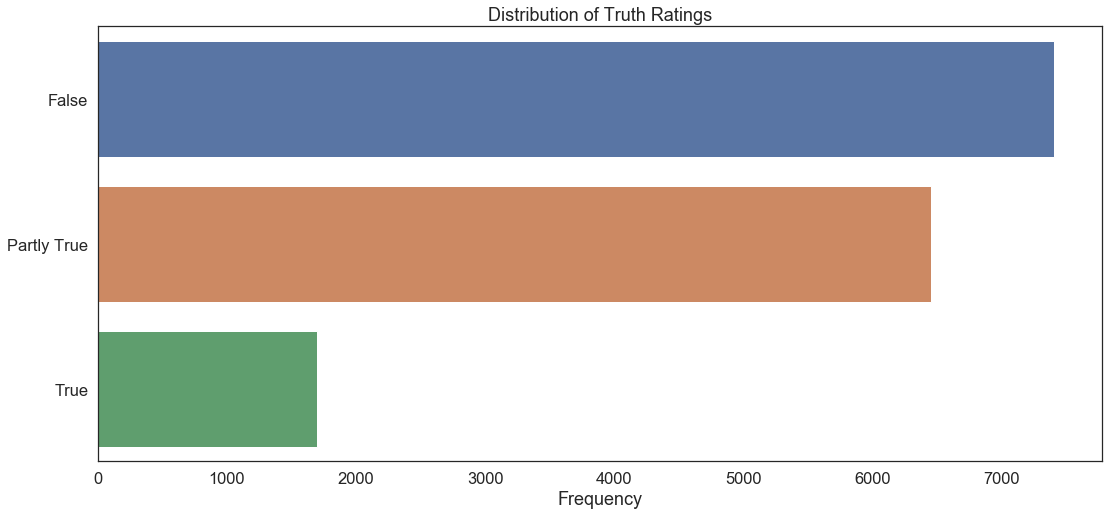

In [0]:
#Plot the Distribution Graph
plt.figure(figsize=(18,8))

sns.set(font_scale = 1.5)
sns.set_style("white")

sns.countplot(y='new_label', data=df, order = ['False','Partly True','True'])

plt.xlabel("Frequency")
plt.ylabel("")
plt.title("Distribution of Truth Ratings")
plt.show()

In the provided training set, the class is slightly imbalanced as we see large counts of false and partly true claims, but relatively small counts of true claims.

### Word Cloud of Claims

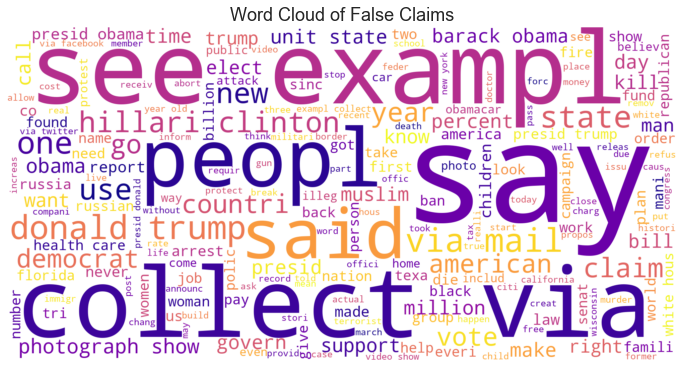

In [0]:
false_claim = [x for x in df[df['label']==0]['clean_joined']]
false_claim = " ".join(false_claim)

wordcloud = WordCloud(width = 2000, height = 1000, max_words=200,background_color="white", colormap = 'plasma').generate(false_claim)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of False Claims')
plt.axis("off")
plt.show()

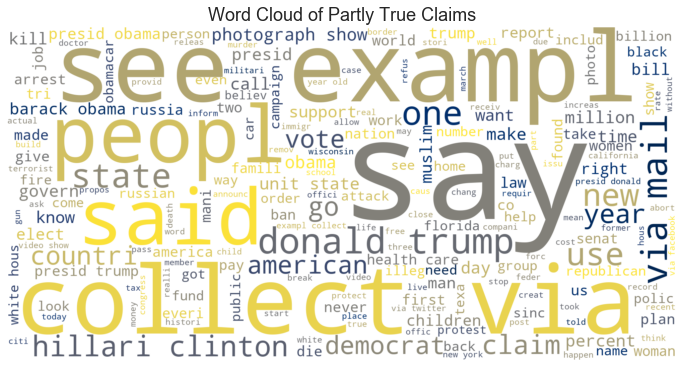

In [0]:
partly_true_claim = [x for x in df[df['label']==0]['clean_joined']]
partly_true_claim = " ".join(partly_true_claim)

wordcloud = WordCloud(width = 2000, height = 1000, max_words=200, background_color = "white", colormap = 'cividis').generate(partly_true_claim)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Partly True Claims')
plt.axis("off")
plt.show()

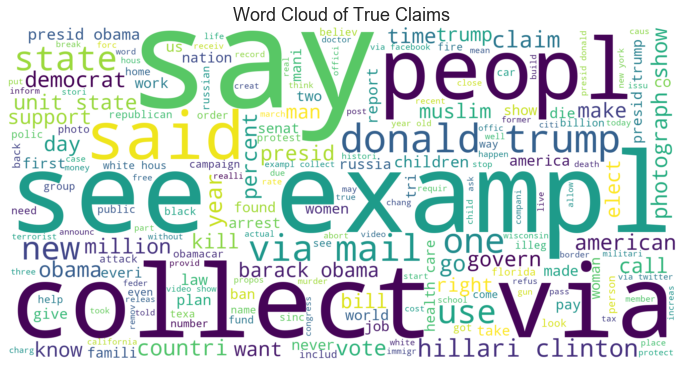

In [0]:
true_claim = [x for x in df[df['label']==0]['clean_joined']]
true_claim = " ".join(true_claim)

wordcloud = WordCloud(width = 2000, height = 1000, max_words=200, background_color = "#FFFFFF").generate(true_claim)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of True Claims')
plt.axis("off")
plt.show()

Upon analyzing the word cloud, the data shows that the most frequently used words such as 'say', 'people', 'see', and 'example' are shared throughout all labels. Additionally, it seems like there aren't a lot of words that are unique to specific labels or categories. 

### Distribution of Claimants

In [0]:
df['claimant'].value_counts().head()

                   4962
Donald Trump       1233
Bloggers            372
Barack Obama        234
Hillary Clinton     220
Name: claimant, dtype: int64

In [0]:
#Impute Empty values to None
df[df['claimant']==''].loc['claimant']= 'None'

In [0]:
df['claimant'].value_counts()

                                               4962
Donald Trump                                   1233
Bloggers                                        372
Barack Obama                                    234
Hillary Clinton                                 220
Viral image                                     127
Facebook posts                                  108
Ted Cruz                                        106
Various websites                                106
Bernie Sanders                                  101
Marco Rubio                                      97
Scott Walker                                     90
John McCain                                      88
Rick Perry                                       77
Rick Scott                                       73
Chain email                                      71
Facebook user                                    71
multiple sources                                 70
Mike Pence                                       60
Jeb Bush    

In [0]:
claimant_list = ['Donald Trump', 'Bloggers', 'Barack Obama', 'Hillary Clinton', 'Viral image', 'Facebook posts', 'Ted Cruz', 'Various websites', 'Chain email','Multiple sources', 'Facebook user']

true_claimant = []
partly_true_claimant =[]
false_claimant = []

#Get the total counts of each truth ratings per claimants
for claimant in claimant_list:
    true_claimant.append(len(df[(df['claimant']== claimant) & (df['label'] == 2)]['claimant']))
    partly_true_claimant.append(len(df[(df['claimant']== claimant) & (df['label'] == 1)]['claimant']))
    false_claimant.append(len(df[(df['claimant']== claimant) & (df['label'] == 0)]['claimant']))

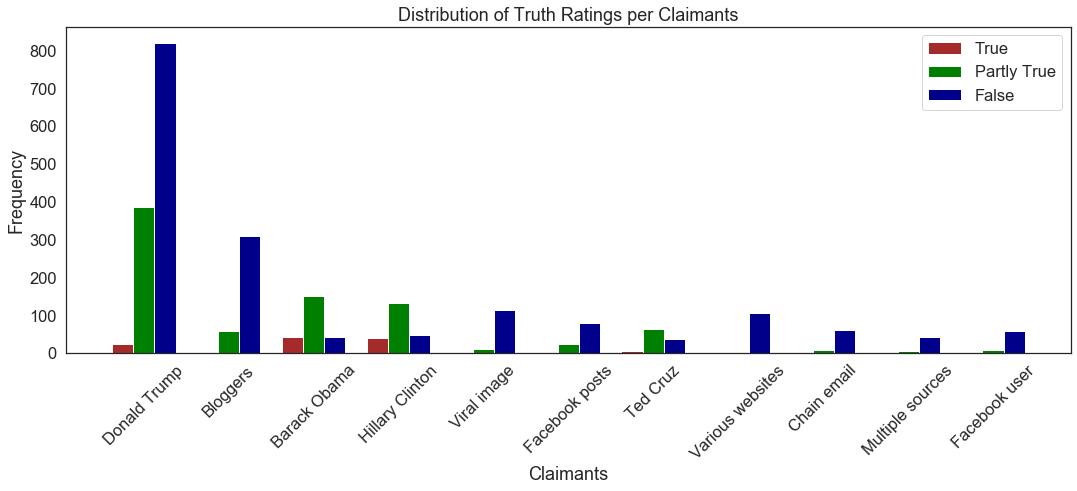

In [0]:
barWidth = 0.25

r1 = np.arange(len(true_claimant))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

width = 0.35

plt.figure(figsize=(18,6))

plt.bar(r1, true_claimant, color='brown', width=barWidth, edgecolor='white', label='True')
plt.bar(r2, partly_true_claimant, color='green', width=barWidth, edgecolor='white', label='Partly True')
plt.bar(r3, false_claimant, color='darkblue', width=barWidth, edgecolor='white', label='False')
plt.xticks([r + barWidth for r in range(len(true_claimant))],claimant_list)

plt.legend()
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.xlabel("Claimants")
plt.title("Distribution of Truth Ratings per Claimants")
plt.show()

Based on the distribution graph above, there are not a lot of data with 'True' label which may cause high distribution towards the False label. For better comparison, we will normalize our data by each frequency with the total count of that label. 

In [0]:
claimant_list = ['Donald Trump', 'Bloggers', 'Barack Obama', 'Hillary Clinton', 'Viral image', 'Facebook posts', 'Ted Cruz', 'Various websites', 'Vladimir Putin', 'Chain email','Multiple sources', 'Facebook user']

true_claimant = []
partly_true_claimant =[]
false_claimant = []

#Get the normalized value of each truth ratings per claimants
for claimant in claimant_list:
    true_claimant.append(len(df[(df['claimant']== claimant) & (df['label'] == 2)]['claimant'])/len(df[df['label'] == 2]))
    partly_true_claimant.append(len(df[(df['claimant']== claimant) & (df['label'] == 1)]['claimant'])/len(df[df['label'] == 1]))
    false_claimant.append(len(df[(df['claimant']== claimant) & (df['label'] == 0)]['claimant'])/len(df[df['label'] == 0]))

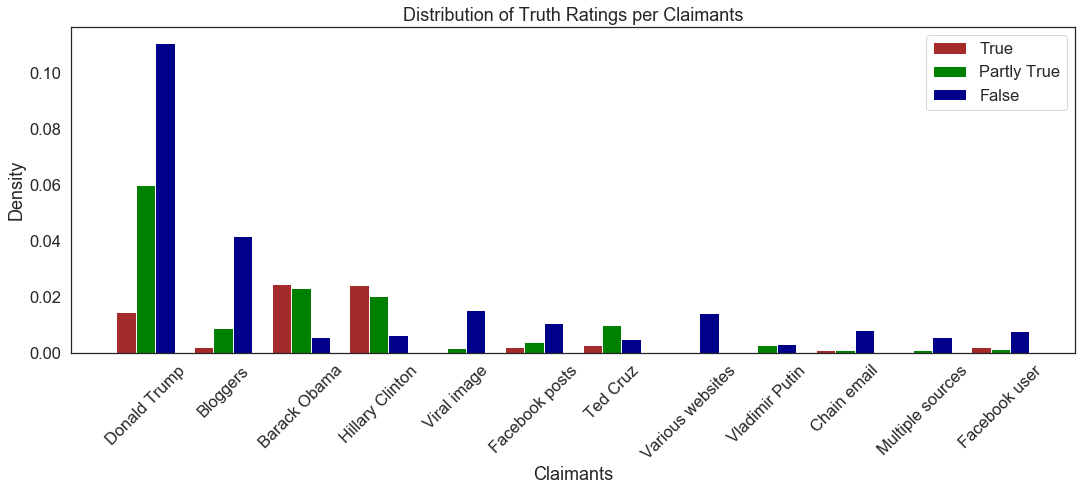

In [0]:
barWidth = 0.25

r1 = np.arange(len(true_claimant))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

width = 0.35

plt.figure(figsize=(18,6))

plt.bar(r1, true_claimant, color='brown', width=barWidth, edgecolor='white', label='True')
plt.bar(r2, partly_true_claimant, color='green', width=barWidth, edgecolor='white', label='Partly True')
plt.bar(r3, false_claimant, color='darkblue', width=barWidth, edgecolor='white', label='False')
plt.xticks([r + barWidth for r in range(len(true_claimant))],claimant_list)

plt.legend()
plt.ylabel("Density")
plt.xticks(rotation=45)
plt.xlabel("Claimants")
plt.title("Distribution of Truth Ratings per Claimants")
plt.show()

Even after normalizing, we can still see a strong relationship between the truth ratings and the claimants. As expected, unreliable sources such as chain email, various website, facebook user, etc. tend to have larger counts for false claims. On the other hand, claimants like Barack Obama and Hiliary Cliinton show larger number of true and partly true claims. 

### Distribution of Number of Words

In [0]:
df['Num_words'] = df['clean_joined'].apply(lambda x: len(x))

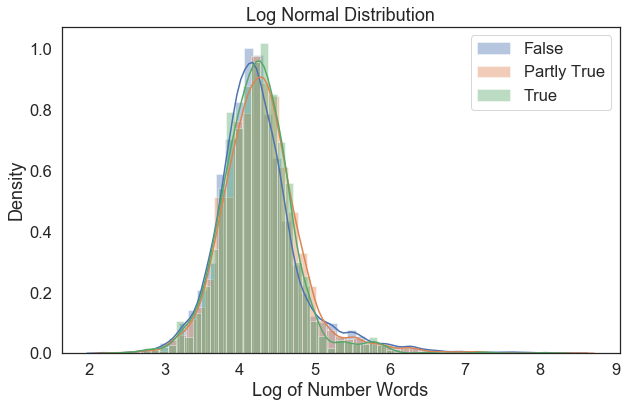

In [0]:
plt.figure(figsize=(10,6))

sns.distplot(np.log1p(df[df['label']==0]['Num_words']),  label="False")
sns.distplot(np.log1p(df[df['label']==1]['Num_words']),  label="Partly True")
sns.distplot(np.log1p(df[df['label']==2]['Num_words']),  label="True")
plt.title("Log Normal Distribution")
plt.xlabel("Log of Number Words")
plt.ylabel("Density")
plt.legend();

The log distribution of the length or number of words in the claim are similar throughout all truth ratings which mean that there are no strong relationship between the labels and the length of the claims.

### Subjectivity and Polarity Using TextBlob

TextBlob is a python library for processing the text data. The library has a built-in sentiment and subjectivity classification. We will explore if the sentiment and subjective ratings from TextBlob have any relationship between the target labels.

In [0]:
polarity_list = []
subjectivity_list = []
for i in range(len(df)):
    polarity, subjectivity = TextBlob(df['claim'][i]).sentiment
    polarity_list.append(polarity)
    subjectivity_list.append(subjectivity)

In [0]:
df['Polarity'] = polarity_list
df['Subjectivity'] = subjectivity_list

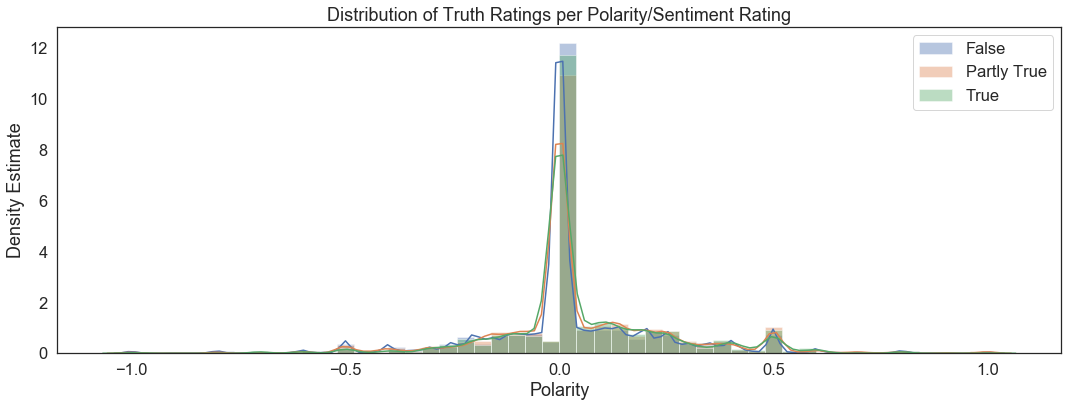

In [0]:
plt.figure(figsize=(18,6))

sns.distplot((df[df['label']==0]['Polarity']),  label="False")
sns.distplot((df[df['label']==1]['Polarity']),  label="Partly True")
sns.distplot((df[df['label']==2]['Polarity']),  label="True")
plt.ylabel("Density Estimate")
plt.legend()
plt.title("Distribution of Truth Ratings per Polarity/Sentiment Rating")
plt.show()

Based on the graph above, the distribution of the polarity or sentiment ratings from TextBlob are almost identical between each labels which means that there are no strong relationship between labels and the sentiment values extracted from TextBlob. 

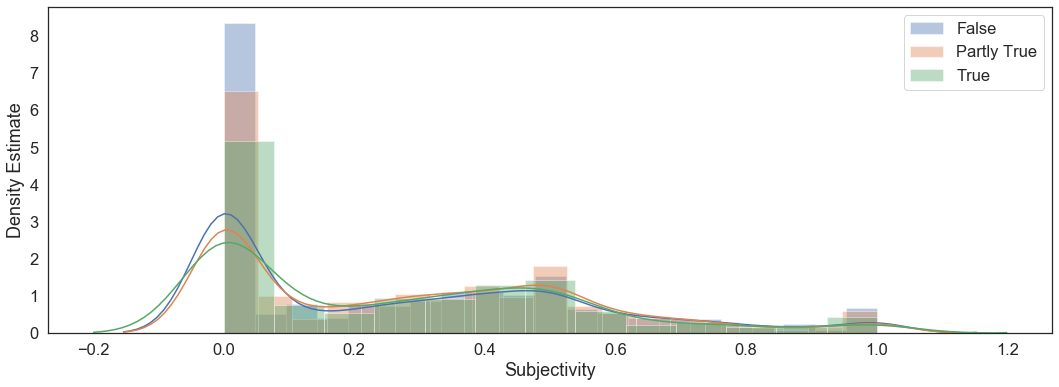

In [0]:
plt.figure(figsize=(18,6))

sns.distplot((df[df['label']==0]['Subjectivity']),  label="False")
sns.distplot((df[df['label']==1]['Subjectivity']),  label="Partly True")
sns.distplot((df[df['label']==2]['Subjectivity']),  label="True")

plt.ylabel("Density Estimate")
plt.legend()
plt.show()

Based on the graph above, the distribution of the subjectivity ratings from TextBlob are almost identical between each labels which means that there are no strong relationship between the labels and the subjectivity ratings extracted from TextBlob

## 3.0 Model Preparation

After performing the EDA, we found that claimants data posess a strong correlation or relationship between our target labels. The claimants data will be used as one of the features for building the predictive model. 

In addition, we believe that claims based on the structure of the words and the content have enough information for the algorithms to correctly predict the truth ratings. Therefore, we will not use the related articles for implementing the model.

In the end, after we determine the best performing model, we will try training the model using related articles and also train without claimants to validate our decision.

In [0]:
X = df['clean_joined'].copy()
y = df['label'].copy()

In [0]:
#One hot Encode the Claimants Data
claimant_dummies = pd.get_dummies(df['claimant'])

#Drop all claimants that have counts less than 99.9% of the dataset
claimant = claimant_dummies.loc[:, (claimant_dummies==0).mean() < .999]

### Feature Extraction

For feature extraction method, we will fit logistic regression on both count vectors methods, bag of words and TF-IDF and compute accuracy as a function of number of features or vocabularies to determine the optimal method and the number of features. Then, in the model implementation, we will try different classifiers with chosen number of features and the method. Logistic regression is chosen as a baseline model as it is computationally scalable to large dataset. For evaluation metric, we are going to use F1 score with average of macro which is the same metric used in the competition. 

In [0]:
def num_feature_accuracy(vectorizer, max_features, classifier, X,y):
    result = []
    best_accuracy = 0
    best_n = 0
    for n in max_features:
        #Bag of Words
        if (vectorizer == CountVectorizer):
            X_transformed = vectorizer(analyzer = 'word', max_features = n).fit_transform(X).toarray()
            
        #TF-IDF
        else:
            X_transformed = vectorizer(analyzer = 'word', max_features = n, use_idf=True, smooth_idf=True, norm = None).fit_transform(X).toarray()
        
        #Add Claimants data to the featurized dataset
        X_with_claimants = np.concatenate((X_transformed,np.array(claimant)), axis = 1)
        
        #Split test and train 
        X_train,X_test,y_train,y_test = train_test_split(X_with_claimants,y, test_size = 0.30, random_state = 5)
        
        model = classifier().fit(X_train,y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_accuracy = f1_score(y_train, y_train_pred,average = 'macro') *100
        test_accuracy = f1_score(y_test, y_test_pred,average = 'macro') *100
        
        result.append((n,test_accuracy))
        
        if best_accuracy < test_accuracy:
            best_accuracy = test_accuracy
            best_n = n
        
    print("Best F1 Score: {:.2f}".format(best_accuracy))
    print("\nThe optimal logistic regression model uses {} number of features and has f1 score of {:.2f}".format(best_n,best_accuracy))
    
    return result

In [0]:
from sklearn.linear_model import LogisticRegression

#Bag of Words
vectorizer = CountVectorizer
classifier = LogisticRegression
n_features = [x for x in range(200,5001,200)]

bow_result = num_feature_accuracy(vectorizer, n_features, classifier, X, y)

Best F1 Score: 45.10

The optimal logistic regression model uses 1200 number of features and has f1 score of 45.10


In [0]:
#TF-IDF
vectorizer = TfidfVectorizer
classifier = LogisticRegression
n_features = [x for x in range(200,5001,200)]

tfidf_result = num_feature_accuracy(vectorizer, n_features, classifier, X, y)

Best F1 Score: 45.82

The optimal logistic regression model uses 1400 number of features and has f1 score of 45.82


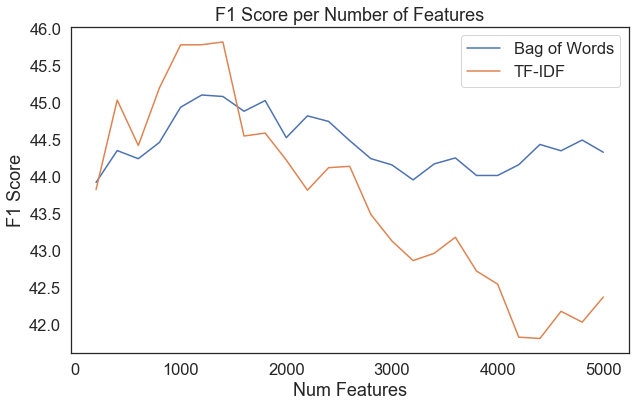

In [0]:
bow_result = pd.DataFrame(bow_result, columns = ['Num Features','F1 Score'])
tfidf_result = pd.DataFrame(tfidf_result, columns = ['Num Features','F1 Score'])

plt.figure(figsize=(10,6))
sns.lineplot(bow_result['Num Features'], bow_result['F1 Score'], label = 'Bag of Words')
sns.lineplot(tfidf_result['Num Features'], tfidf_result['F1 Score'], label = 'TF-IDF')
plt.title("F1 Score per Number of Features")
plt.legend()
plt.show()

Based on the graph above, we can see that both bag of words and tf-idf start to overfit after 1400 features resulting in lower test accuracy. And for f1 score between methods, TFIDF yields better results than bag of words at its peak, but tends to fall off as the accuracy go down. Therefore, we will featurize our data using TF-IDF of 1400 features as it was the best performing model. 

In [0]:
X = df['clean_joined'].copy()
y = df['label'].copy()

In [0]:
#Featurize the data using TF-IDF with 1400 features
tf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word', max_features = 1400)

train_data_features = tf_vectorizer.fit_transform(X)
train_data_features = train_data_features.toarray()

feature_names = tf_vectorizer.get_feature_names()

X = pd.DataFrame(train_data_features, columns = feature_names)

In [0]:
X_with_claimants = pd.concat([X,claimant], axis = 1)

In [0]:
#Split dataset into train and test set
X_train,X_test,y_train,y_test = train_test_split(X_with_claimants,y, test_size = 0.30, random_state = 5)

## 4.0 Model Implementation

The best result we got with logistic regression was 45.82% by using TF-IDF of 1400 features. With these parameters, we will fit various models and compare their test accuracy. Then, we will select the classifier with highest accuracy and further tune the hyperparameters of the model to achieve best performance.

#### Training with ML Classifiers

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
#List of Models to Train with
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('Naive Bayes Multinomial', MultinomialNB()))
models.append(('Naive Bayes Bernoulli', BernoulliNB()))
models.append(('SVM', LinearSVC()))
models.append(('XGBoost', XGBClassifier()))
models.append(('RandomForest',RandomForestClassifier()))
models.append(('Decision Tree',DecisionTreeClassifier()))

In [0]:
model_score = []

for classifier, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = f1_score(y_train, y_train_pred,average = 'macro') *100
    test_accuracy = f1_score(y_test, y_test_pred,average = 'macro') *100
    
    model_score.append((classifier, test_accuracy))
    print("With Classifier: {}, F1 Train Score: {:.2f}, and F1 Test Score {:.2f}".format(classifier,train_accuracy,test_accuracy))    

With Classifier: Logistic Regression, F1 Train Score: 60.66, and F1 Test Score 45.82
With Classifier: LDA, F1 Train Score: 61.89, and F1 Test Score 46.63
With Classifier: Naive Bayes Multinomial, F1 Train Score: 55.03, and F1 Test Score 46.06
With Classifier: Naive Bayes Bernoulli, F1 Train Score: 54.29, and F1 Test Score 47.36
With Classifier: SVM, F1 Train Score: 60.04, and F1 Test Score 44.96
With Classifier: XGBoost, F1 Train Score: 44.34, and F1 Test Score 43.98
With Classifier: RandomForest, F1 Train Score: 97.18, and F1 Test Score 43.01
With Classifier: Decision Tree, F1 Train Score: 99.88, and F1 Test Score 43.24


#### Training with Neural Networks

To implement the neural network model, we will use the library Tensorflow. Also, unlike other classifiers, we will split our data into train, test and validation. When training, early stopping will be implemented to ensure the model doesn't overfit to the train set. 

In [0]:
import tensorflow as tf

In [0]:
#Split the Train data into Train data and validation data
X_train_ml,X_val_ml,y_train_ml,y_val_ml = train_test_split(X_train,y_train, test_size = 0.20)

In [0]:
#Convert Pandas data frame into np.array
X_train_ml = X_train_ml.values
X_val_ml = X_val_ml.values
y_train_ml = y_train_ml.values
y_val_ml = y_val_ml.values

In [0]:
#Convert Pandas data frame into np.array
X_test_ml = X_test.values
y_test_ml = y_test.values

In [0]:
# Set the input and output sizes
output_size = 3
hidden_layer_size = 500
    
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# set the batch size
batch_size = 100

# set a maximum number of training epochs
max_epochs = 100

# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
model.fit(X_train_ml, # train inputs
          y_train_ml, # train targets
          batch_size=batch_size, # batch size
          epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
          # callbacks are functions called by a task when a task is completed
          # task here is to check if val_loss is increasing
          validation_data=(X_val_ml, y_val_ml), # validation data
          callbacks=[early_stopping], # early stopping
          )  

Train on 8710 samples, validate on 2178 samples
Epoch 1/100
8710/8710 [==============================] - 2s 194us/sample - loss: 0.9512 - accuracy: 0.5598 - val_loss: 0.9114 - val_accuracy: 0.5886
Epoch 2/100
8710/8710 [==============================] - 1s 128us/sample - loss: 0.6210 - accuracy: 0.7460 - val_loss: 1.0140 - val_accuracy: 0.5771
Epoch 3/100
8710/8710 [==============================] - 1s 117us/sample - loss: 0.3357 - accuracy: 0.8817 - val_loss: 1.2599 - val_accuracy: 0.5753


In [0]:
#Get Loss and Train accuracy
y_pred_test = model.predict_classes(X_test_ml, verbose = 0)
test_accuracy = f1_score(y_test_ml, y_pred_test,average = 'macro') *100

print("The F1 Score using neural network is {:.2f}%".format(test_accuracy))

model_score.append(("Neural Network", test_accuracy))

The F1 Score using neural network is 44.06%


## 5.0 Results and Discussion

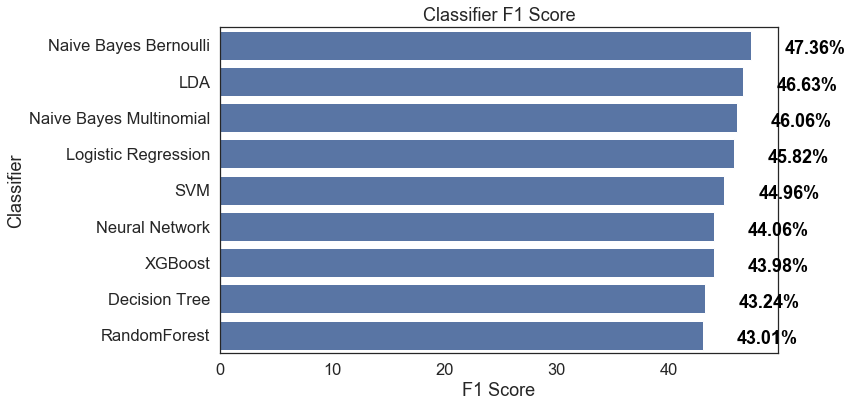

In [0]:
model_score = pd.DataFrame(model_score, columns = ['Classifier', 'Test Accuracy'])
model_score = model_score.sort_values(by=['Test Accuracy'], ascending = False) 

plt.figure(figsize=(10,6))
sns.barplot(x='Test Accuracy', y='Classifier', data=model_score, color="b")

for i, v in enumerate(model_score['Test Accuracy']):
    plt.text(v + 3, i + .25, str(round(v,2)) + '%', color='black', fontweight='bold')

plt.xlabel('F1 Score')
plt.title('Classifier F1 Score')
plt.show()

After performing eight different classifiers, Naive Bayes Bernoulli was computed to be the best performing classifier. 

### Hyperparameter Tuning

The best performing classifer was found to be Bernoulli Naive Bayes. Therefore, we will tune the hyperparameter of Bernoulli Naive Bayes to build the best performing model.

In [0]:
alpha_list = [0,0.001,0.005,0.01,0.05,0.1,0.2,0.4,0.6,0.8,1]
binarize_list = [0,0.01,0.05,0.1,0.2,0.4,0.6,0.8,1,5,10]
best_score = 0
best_alpha = 0
best_binarize = 0

for binarize in binarize_list:
    for alpha in alpha_list:
        model = BernoulliNB(alpha = alpha, binarize = binarize).fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_accuracy = f1_score(y_train, y_train_pred,average = 'macro') *100
        test_accuracy = f1_score(y_test, y_test_pred,average = 'macro') *100
        
        if best_score < test_accuracy:
            best_score = test_accuracy
            best_alpha = alpha
            best_binarize = binarize
            
print("The optimal Naive Bayes Model uses alpha = {} and binarize = {}".format(best_alpha,best_binarize))
print("\nThe Best F1 Score: {:.2f}%".format(best_score))

The optimal Naive Bayes Model uses alpha = 0.005 and binarize = 0

The Best F1 Score: 47.64%


After hyperparameter tuning, the best f1 score is computed to be 47.64% which is slightly better than the default parameters.

In [0]:
#Fit model again with optimal hyperparameters
model = BernoulliNB(alpha = .005, binarize = 0).fit(X_train, y_train)
y_test_pred = model.predict(X_test)

### Confusion Matrix

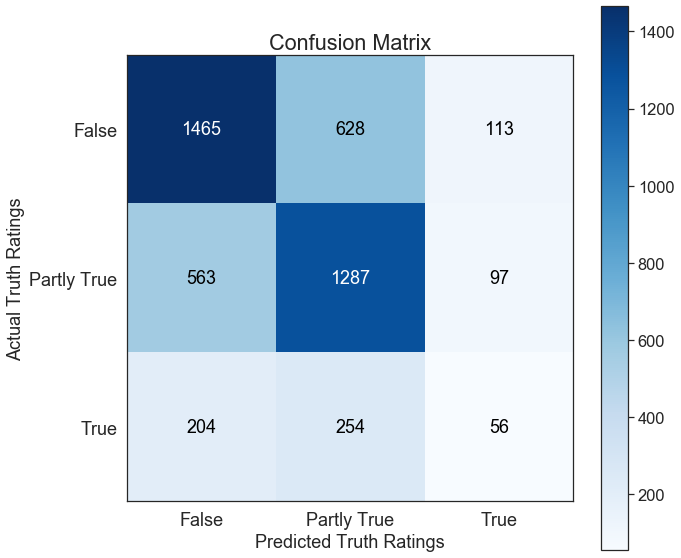

In [0]:
import scikitplot as skplt

y_test_cm = y_test.copy()
y_test_pred_cm = pd.DataFrame(y_test_pred, index = y_test_cm.index)

labels = {0:'False',1:'Partly True', 2: 'True'}

y_test_cm.replace(labels, inplace = True)
y_test_pred_cm.replace(labels,inplace = True)

#Plot Confusion Matrix
skplt.metrics.plot_confusion_matrix(
    y_test_cm, 
    y_test_pred_cm,
    figsize=(10,10))

plt.ylabel("Actual Truth Ratings")
plt.xlabel("Predicted Truth Ratings")
plt.show()

After plotting the confusion matrix, we can see that the model predicts false and partly true labels correctly majority of the time whereas for true label, it does not. This may be due to the imbalance in the dataset which we saw in the EDA. We may achieve higher performance if the model was provided with larger datasets with uniform classes or labels. 

### Training without Claimants

As mentioned above, we will build a model without the claimant data to validate that training with claimant data helps to improve the performance. We will use Bernoulli's Naive Bayes with same hyperparameter as it yielded the best performance in the previous model.

In [0]:
X_train_no_claimants,X_test_no_claimants,y_train,y_test = train_test_split(X,y, test_size = 0.30, random_state = 5)

In [0]:
model = BernoulliNB(alpha = 0.005).fit(X_train_no_claimants, y_train)

y_train_pred = model.predict(X_train_no_claimants)
y_test_pred = model.predict(X_test_no_claimants)
train_accuracy = f1_score(y_train, y_train_pred,average = 'macro') *100
test_accuracy = f1_score(y_test, y_test_pred,average = 'macro') *100

print("The F1 score of the model without claimant data is {:.2f}%".format(test_accuracy))

The F1 score of the model without claimant data is 45.10%


The model without the claimant data computed f1 score as 45.10% which is less than the model with claimants. The claimant data helps to improve the model performance.



### Training with Related Articles

In addition to the claimants, we also wanted to validate that training the model without the related articles data yields better performance. We will train the model with related articles and compare the performance. Again, the model will be trained using Bernoulli's Naive Bayes with same hyperparmeter as the previous model.

In [0]:
#Featurize the data using TF-IDF with 1400 features for related articles
tf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word', max_features = 1400)

train_data_features = tf_vectorizer.fit_transform(df['clean_article_joined'])
train_data_features = train_data_features.toarray()

feature_names = tf_vectorizer.get_feature_names()

X_article = pd.DataFrame(train_data_features, columns = feature_names)

In [0]:
#Combine Related Articles, Claimants, Claims into X
X_with_related_articles = pd.concat([X_article,X_with_claimants], axis = 1)

In [0]:
#Split dataset into train and test set
X_train,X_test,y_train,y_test = train_test_split(X_with_related_articles,y, test_size = 0.30, random_state = 5)

In [0]:
#Fit model with optimal hyperparameters
model = BernoulliNB(alpha = 0.005).fit(X_train, y_train)
y_test_pred = model.predict(X_test)

In [0]:
test_accuracy = f1_score(y_test, y_test_pred,average = 'macro') *100

In [0]:
print("The F1 score using related articles is {:.2f}%".format(test_accuracy))

The F1 score using related articles is 45.41%


The F1 score using the dataset with related articles yielded 45.41% which is lower than the accuracy of the model without the related articles. Additionally, the model with related articles do not seem to outperform significantly compared to the model trained without claimants and related articles.

We will try with top 3 classifiers other than Bernoulli's Naive Bayes that resulted the best outcome and see if the f1 score increases.

In [0]:
#List of Models to Train with
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('Naive Bayes Multinomial', MultinomialNB()))

In [0]:
model_score = []

for classifier, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = f1_score(y_train, y_train_pred,average = 'macro') *100
    test_accuracy = f1_score(y_test, y_test_pred,average = 'macro') *100
    
    model_score.append((classifier, test_accuracy))
    print("With Classifier: {}, F1 Train Score: {:.2f}, and F1 Test Score {:.2f}".format(classifier,train_accuracy,test_accuracy))    

With Classifier: Logistic Regression, F1 Train Score: 67.17, and F1 Test Score 43.66
With Classifier: LDA, F1 Train Score: 73.09, and F1 Test Score 45.22
With Classifier: Naive Bayes Multinomial, F1 Train Score: 49.50, and F1 Test Score 45.21


Even after training with different classifiers, the f1 score does not seem to increase. 

Based on the observations above, just within the claims data, there is a pattern that the model can analyze and learn to predict the truth ratings corectly.